In [1]:
import zipfile
import os
import gdown

# URL of the Google Drive file
zip_file_url = "https://drive.google.com/uc?id=1lkHxnl75ubNgQbqIIW8ihwcx-XA3-nr3"
local_zip_path = "downloaded_file.zip"

# Download the file using gdown
gdown.download(zip_file_url, local_zip_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1lkHxnl75ubNgQbqIIW8ihwcx-XA3-nr3
From (redirected): https://drive.google.com/uc?id=1lkHxnl75ubNgQbqIIW8ihwcx-XA3-nr3&confirm=t&uuid=c3ab1517-3d1b-4a78-a914-a17a8d72e386
To: /content/downloaded_file.zip
100%|██████████| 4.21G/4.21G [00:56<00:00, 73.8MB/s]


'downloaded_file.zip'

In [2]:
output_folder = '/content'

In [3]:
import librosa
import numpy as np
import scipy
import soundfile as sf

#preprocessing parameters
frame_length = 1024          # 23 ms for a 44.1 kHz sample rate
hop_length = 512             # 50% overlap
sample_rate = 16000          # Common for ASR
pre_emphasis_coefficient = 0.95

Data Processing

In [4]:
# Unzipping function and preprocessing function combined
def extract_and_preprocess(zip_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_folder)

    for root, _, files in os.walk(output_folder):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                audio, sr = librosa.load(file_path, sr=sample_rate)

                # Apply preprocessing steps
                audio = remove_silence(audio, sr)
                audio = noise_reduction(audio, sr)
                audio = pre_emphasis(audio)
                frames = librosa.util.frame(audio, frame_length=1024, hop_length=512).T
                windowed_frames = frames * scipy.signal.windows.hann(1024)
                normalized_frames = cmvn(windowed_frames)
                audio_reconstructed = overlap_add(normalized_frames, 512)
                audio_reconstructed = apply_gain(audio_reconstructed)

                # Save processed audio
                save_path = file_path.replace(".wav", "_processed.wav")
                sf.write(save_path, audio_reconstructed, sr)
                print(f"Processed and saved: {save_path}")


In [5]:
# Voice Activity Detection (VAD)
def remove_silence(audio, sr, threshold=0.01, duration=0.1):
    initial_samples = int(duration * sr)
    preserved_part = audio[:initial_samples]
    remaining_part = audio[initial_samples:]
    mask = np.abs(preserved_part) > threshold
    vad_part = preserved_part[mask]
    return np.concatenate((vad_part, remaining_part))


In [6]:
# Noise Reduction
def noise_reduction(audio, sr, sample_segment_duration=0.05):
    sample_segment = audio[:int(sample_segment_duration * sr)]
    noise_profile = np.mean(sample_segment)
    return audio - noise_profile


In [7]:
# Pre-Emphasis
def pre_emphasis(audio, coeff=0.97):
    return np.append(audio[0], audio[1:] - coeff * audio[:-1])


In [8]:
# Cepstral Mean and Variance Normalization (CMVN)
def cmvn(frames):
    mean = np.mean(frames, axis=0)
    std_dev = np.std(frames, axis=0)
    return (frames - mean) / (std_dev + 1e-8)


In [9]:
# Overlap-Add Method for Reconstruction
def overlap_add(frames, hop_length):
    audio_reconstructed = np.zeros((frames.shape[0] - 1) * hop_length + frames.shape[1])
    for i, frame in enumerate(frames):
        audio_reconstructed[i * hop_length : i * hop_length + len(frame)] += frame
    return audio_reconstructed


In [10]:
# Apply Gain
def apply_gain(audio, gain_factor=1.1):
    amplified_audio = audio * gain_factor
    max_val = np.max(np.abs(amplified_audio))
    if max_val > 1.0:
        amplified_audio /= max_val
    return amplified_audio


In [11]:
# Run the preprocessing on the dataset
extract_and_preprocess(local_zip_path, output_folder)

Streaming output truncated to the last 5000 lines.
Processed and saved: /content/audio/audio/train/39909/audio_processed.wav
Processed and saved: /content/audio/audio/train/222307/audio_processed.wav
Processed and saved: /content/audio/audio/train/241835/audio_processed.wav
Processed and saved: /content/audio/audio/train/94882/audio_processed.wav
Processed and saved: /content/audio/audio/train/52357/audio_processed.wav
Processed and saved: /content/audio/audio/train/121669/audio_processed.wav
Processed and saved: /content/audio/audio/train/309643/audio_processed.wav
Processed and saved: /content/audio/audio/train/197236/audio_processed.wav
Processed and saved: /content/audio/audio/train/36844/audio_processed.wav
Processed and saved: /content/audio/audio/train/181010/audio_processed.wav
Processed and saved: /content/audio/audio/train/118506/audio_processed.wav
Processed and saved: /content/audio/audio/train/149819/audio_processed.wav
Processed and saved: /content/audio/audio/train/25909

In [12]:
root_folder = "/content"

In [ ]:
import json
import re

def load_text_files(root_folder):
    text_data = {}

    for root, _, files in os.walk(root_folder):
        for file in files:
            if file == 'text.json':
                with open(os.path.join(root, file), 'r') as f:
                    text_content = json.load(f)
                    text_data[root] = preprocess_text(text_content.get("text", ""))
            elif file == 'alignment.txt':
                with open(os.path.join(root, file), 'r') as f:
                    text_content = f.read()
                    text_data[root] = preprocess_text(text_content)

    return text_data

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip() 
    return text

Feature Extraction

In [ ]:
# Feature extraction parameters
n_mfcc = 13               # Number of MFCCs to extract
n_fft = 2048              # Length of the FFT window
hop_length = 512          # Number of samples between successive frames
n_mels = 128              # Number of Mel bands to generate

In [15]:
def extract_features(file_path, sr=16000):
    audio, _ = librosa.load(file_path, sr=sr)

    # Set n_fft based on the audio length
    n_fft = min(2048, len(audio))

    # Extract MFCCs and Mel Spectrogram with adjusted parameters
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # Adjust `fmax` and `n_mels` if needed
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=min(n_mels, n_fft // 2 + 1), fmax=sr // 2)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return mfccs, mel_spectrogram

In [16]:
# Apply feature extraction to each preprocessed audio file
def extract_features_from_dataset(root_folder):
    feature_data = {}

    for root, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith("_processed.wav"):
                file_path = os.path.join(root, file)

                # Extract features
                mfccs, mel_spectrogram = extract_features(file_path)

                # Store features
                feature_data[file_path] = {
                    'mfccs': mfccs,
                    'mel_spectrogram': mel_spectrogram
                }

                # Print or save a summary of the extracted features
                print(f"Extracted features for {file_path}")

    return feature_data

In [17]:
# Run the feature extraction on the dataset
processed_audio_folder = "/content"
features = extract_features_from_dataset(processed_audio_folder)

Streaming output truncated to the last 5000 lines.
Extracted features for /content/audio/audio/train/39909/audio_processed.wav
Extracted features for /content/audio/audio/train/222307/audio_processed.wav
Extracted features for /content/audio/audio/train/241835/audio_processed.wav
Extracted features for /content/audio/audio/train/94882/audio_processed.wav
Extracted features for /content/audio/audio/train/52357/audio_processed.wav
Extracted features for /content/audio/audio/train/121669/audio_processed.wav
Extracted features for /content/audio/audio/train/309643/audio_processed.wav
Extracted features for /content/audio/audio/train/197236/audio_processed.wav
Extracted features for /content/audio/audio/train/36844/audio_processed.wav
Extracted features for /content/audio/audio/train/181010/audio_processed.wav
Extracted features for /content/audio/audio/train/118506/audio_processed.wav
Extracted features for /content/audio/audio/train/149819/audio_processed.wav
Extracted features for /conte

In [42]:
import os
import torchaudio
import torchaudio.transforms as T

# Function to extract MFCCs and Mel spectrogram from an audio file
def extract_features(file_path):
    # Load audio file
    waveform, sample_rate = torchaudio.load(file_path)

    # Resample to 16000 Hz if not already at that rate
    if sample_rate != 16000:
        resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    # Compute MFCCs
    mfcc_transform = T.MFCC(
        sample_rate=16000,
        n_mfcc=13,
        melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False},
    )
    mfccs = mfcc_transform(waveform)

    # Compute Mel spectrogram
    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=16000,
        n_fft=400,
        hop_length=160,
        n_mels=23,
        center=False
    )
    mel_spectrogram = mel_spectrogram_transform(waveform)

    return mfccs, mel_spectrogram

# Apply feature extraction to each preprocessed audio file
def extract_features_from_dataset(root_folder):
    feature_data = {}

    for root, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith("_processed.wav"):
                file_path = os.path.join(root, file)

                # Extract features
                mfccs, mel_spectrogram = extract_features(file_path)

                # Store features
                feature_data[file_path] = {
                    'mfccs': mfccs,
                    'mel_spectrogram': mel_spectrogram
                }

                # Print a summary of the extracted features
                print(f"Extracted features for {file_path}")
                print("MFCCs Shape:", mfccs.shape)
                print("Mel Spectrogram Shape:", mel_spectrogram.shape)
                print("-" * 80)

    return feature_data

# Run the feature extraction on the dataset
processed_audio_folder = "/content"
features = extract_features_from_dataset(processed_audio_folder)

# Print the extracted features
for file_path, feature_dict in features.items():
    print(f"Features for {file_path}:")
    print("MFCCs:", feature_dict['mfccs'])
    print("Mel Spectrogram:", feature_dict['mel_spectrogram'])
    print("=" * 100)


Streaming output truncated to the last 5000 lines.
         [   5.8674,    6.8948,    7.4466,  ...,    5.6561,    5.9245,
             6.0269]]])
Mel Spectrogram: tensor([[[0.0061, 0.0052, 0.0105,  ..., 0.0150, 0.0043, 0.0062],
         [0.0124, 0.0223, 0.0412,  ..., 0.0718, 0.0317, 0.0128],
         [0.0255, 0.0177, 0.0318,  ..., 0.0642, 0.0230, 0.0256],
         ...,
         [0.0013, 0.0031, 0.0063,  ..., 0.0136, 0.0027, 0.0012],
         [0.0009, 0.0012, 0.0022,  ..., 0.0045, 0.0020, 0.0009],
         [0.0010, 0.0010, 0.0018,  ..., 0.0033, 0.0018, 0.0011]]])
Features for /content/audio/audio/train/172370/audio_processed.wav:
MFCCs: tensor([[[-35.5844, -48.8186, -35.8619,  ..., -39.0617, -49.1633, -57.7786],
         [ 13.0567,   6.0704,  -2.2598,  ..., -19.2485, -15.7893, -19.1519],
         [  0.6237,  -3.7540, -11.0882,  ..., -27.4626, -24.6571, -17.5961],
         ...,
         [  1.2270,  -4.0184,  -6.0536,  ...,  -7.1963,  -8.3739,  -7.5232],
         [  1.5782,  -0.0833,   1.

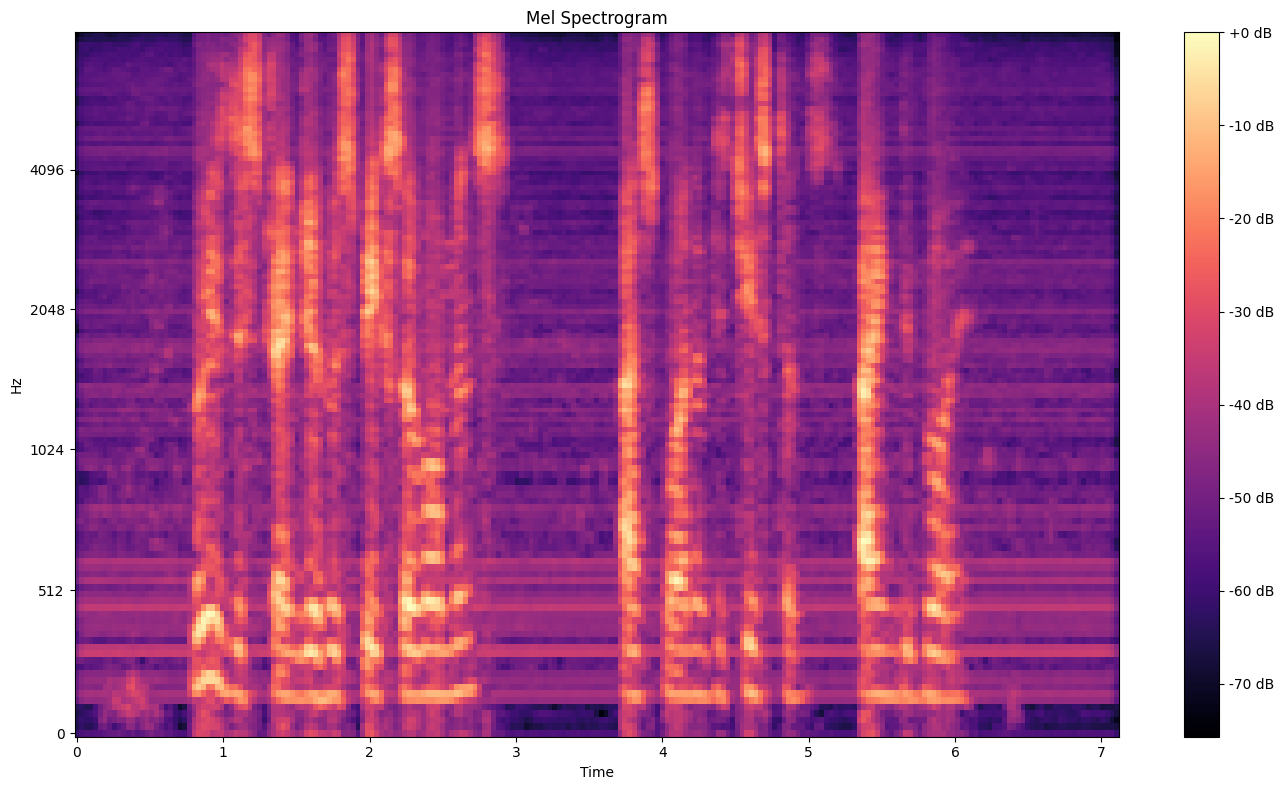

In [54]:
import librosa.display
import matplotlib.pyplot as plt

# Function to plot Mel Spectrogram
def plot_mel_spectrogram(audio_path, sr=16000):
    # Load the audio file
    audio, _ = librosa.load(audio_path, sr=sr)

    # Generate Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=sr//2)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plot Mel Spectrogram
    plt.figure(figsize=(14, 8))
    librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr)
    plt.title('Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Example usage (replace with actual file path)
audio_path = "/content/audio/audio/train/92/audio_processed.wav"
plot_mel_spectrogram(audio_path)


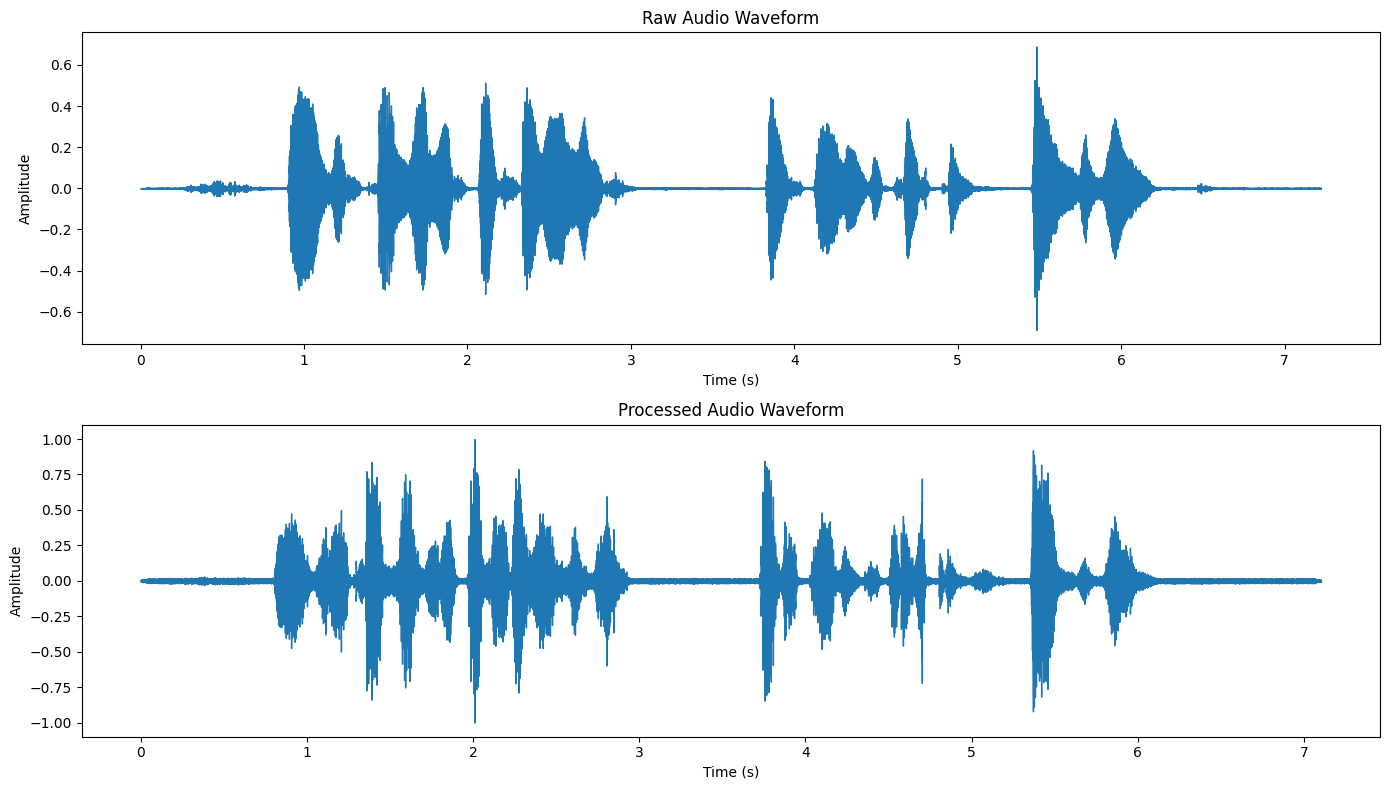

In [18]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_audio_comparison(raw_audio_path, processed_audio_path):
    # Load raw audio
    raw_audio, sr_raw = librosa.load(raw_audio_path, sr=None)
    # Load processed audio
    processed_audio, sr_processed = librosa.load(processed_audio_path, sr=None)

    plt.figure(figsize=(14, 8))

    # Raw audio waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(raw_audio, sr=sr_raw)
    plt.title('Raw Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Processed audio waveform
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(processed_audio, sr=sr_processed)
    plt.title('Processed Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Paths to raw and processed audio files
raw_audio_path = "/content/audio/audio/train/92/audio.wav"
processed_audio_path = "/content/audio/audio/train/92/audio_processed.wav"

# Plot the comparison
plot_audio_comparison(raw_audio_path, processed_audio_path)

MODEL

In [ ]:
import os
import shutil
import json

# Paths
base_path = "/content/audio/audio"
sets = ['train', 'test']  # Only include 'train' and 'test' for the new folder
output_path = "/content/dataset_limited"

# Limits for the number of samples to process
limits = {
    'train': 10000,
    'test': 50
}

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Function to generate transcript from text.json
def create_transcript(text_file):
    with open(text_file, 'r') as f:
        data = json.load(f)

    # Extract words to form transcript
    words = [word_info['word'] for word_info in data['words']]
    transcript = ' '.join(words)
    return transcript

# Loop over each set (train, test)
for dataset in sets:
    dataset_path = os.path.join(base_path, dataset)
    output_dataset_path = os.path.join(output_path, dataset)
    os.makedirs(output_dataset_path, exist_ok=True)

    # Counter to limit the number of samples processed
    sample_count = 0
    max_samples = limits[dataset]

    # Loop over each sample folder
    for sample_folder in os.listdir(dataset_path):
        # Stop if the limit is reached
        if sample_count >= max_samples:
            break

        sample_path = os.path.join(dataset_path, sample_folder)
        output_sample_path = os.path.join(output_dataset_path, sample_folder)
        os.makedirs(output_sample_path, exist_ok=True)

        # Paths to the required files
        audio_file = os.path.join(sample_path, "audio.wav")
        text_file = os.path.join(sample_path, "text.json")
        transcript_file = os.path.join(output_sample_path, "transcript.txt")

        # Check if both files exist
        if os.path.isfile(audio_file) and os.path.isfile(text_file):
            # Copy audio file to the new location
            shutil.copy(audio_file, output_sample_path)

            # Create transcript from text.json and save it
            transcript = create_transcript(text_file)
            with open(transcript_file, 'w') as f:
                f.write(transcript)

            # Increment the counter
            sample_count += 1

        else:
            print(f"Missing files in {sample_path}")

print("Processed limited data has been saved to:", output_path)


Processed limited data has been saved to: /content/dataset_limited


In [47]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import torchaudio
import os
from jiwer import wer  # Ensure jiwer is installed: pip install jiwer

# Load model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to("cpu")

# Define base path and sets
base_path = "/content/dataset_limited"
sets = ['train', 'test']

# Function to process a single sample and get the transcription
def map_to_pred(audio_array):
    input_values = processor(audio_array, return_tensors="pt", padding="longest").input_values.to("cpu")
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    return transcription[0]

# Loop through each set and collect predictions and ground truths for WER calculation
for set_name in sets:
    set_path = os.path.join(base_path, set_name)
    predictions = []
    ground_truths = []

    for sample_folder in os.listdir(set_path):
        sample_path = os.path.join(set_path, sample_folder)

        # Paths to audio and transcript
        audio_path = os.path.join(sample_path, "audio.wav")
        transcript_path = os.path.join(sample_path, "transcript.txt")

        # Check if both files exist
        if os.path.exists(audio_path) and os.path.exists(transcript_path):
            # Load and resample audio
            waveform, sample_rate = torchaudio.load(audio_path)
            if sample_rate != 16000:
                waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

            # Flatten waveform to numpy array
            audio_array = waveform.squeeze().numpy()

            # Predict transcription
            transcription = map_to_pred(audio_array)
            predictions.append(transcription)

            # Load the ground truth transcript
            with open(transcript_path, "r") as f:
                ground_truth = f.read().strip()
            ground_truths.append(ground_truth)

            # Print individual results (optional)
            print(f"Sample Folder: {sample_folder}")
            print(f"Predicted: {transcription}")
            print(f"Ground Truth: {ground_truth}")
            print("-" * 80)

    # Calculate WER for the entire set
    print(f"WER for {set_name} set:", wer(ground_truths, predictions))


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 99977
Predicted: WITHOUT A SINGLE QUIVAR
Ground Truth: without a single quiver
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 119925
Predicted: BECAUSE HE WAS DETIFIED THE BOY DIDN'T DANSER
Ground Truth: because he was terrified the border in dances
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 138544
Predicted: YOU ARE IN THE BEZE
Ground Truth: you are in the business
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 325038
Predicted: THE GARAMAN WOULD BE LUCKY TO REST THE OISES
Ground Truth: a calling would be lucky to rethelois
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 277544
Predicted: I WILL SEE THAT SHE GITS THE FLOWER
Ground Truth: i will see that she is of a
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 215994
Predicted: HORRO AR HUMES BE
Ground Truth: are
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 109006
Predicted: ANE TO WALK TO NEW YORK
Ground Truth: want to walk to new york
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 123771
Predicted: I'M GOING WITH YOU THE BOY SAID
Ground Truth: angling with you the boy said
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 60079
Predicted: THE STRANGE HOARSEMAN DREW IN ANARMUS CURVED FORWARD FROM A SKIBARD MOUNTED ON HIS SADDLE
Ground Truth: the strange horseman grew in an arms coves ford from a cabaret on a saddle
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 141464
Predicted: HEIS DOING IT BECAUSE IT'S WHAT HE WANTS TO DO
Ground Truth: his doings because it's what he wants to do
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 278206
Predicted: YOU AN THE MUN
Ground Truth: you want the man
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 33502
Predicted: THERE WAS EN OF THIT BY A LOT OF EPANS
Ground Truth: there was inhabited by a lot of em
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 241937
Predicted: THER WERE TRAPS WHEN DRESSED IN BLUE BLACK RINK SAT ON IN THEIR TURBANCS
Ground Truth: there were traps when dressed in lowering saronides
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 170910
Predicted: AND I LIKE TO HAVE ITIT
Ground Truth: at the last to part
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 324767
Predicted: THE ILLUMINATION CREATED A COSY ATMOSP
Ground Truth: the illumination create repose as most
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 339005
Predicted: MORMUT PLAYS OFTEN WITH THE COMPUTER
Ground Truth: mama please often with the computer
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 145328
Predicted: I HEARD WHAT YOU WERE TALKING ABOUT THE OTHURDAY WITH THE ELE COMMINCED THE VAIN SAID
Ground Truth: i hear or to a daring able the thirtieth i commend the wanted
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 165236
Predicted: HIS FATE WAS UNSTAVEN
Ground Truth: if she was in stable
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 135529
Predicted: TO RECOGNIZE IN GREAT REDAN
Ground Truth: there are the main great rider
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 268891
Predicted: WERE THE BLUE ONE
Ground Truth: that the blue one
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 236028
Predicted: I DON'T KNOW WHO ANYBODY IS ANY
Ground Truth: i don't know anybody is
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 280830
Predicted: HAD OUR INSTRUMENTS PERMITTED IT WE MIGHT HAVE BEEN ABLE TO SEE THE TROUBLE WAY BACK WHEN
Ground Truth: here instruments but a mere it we might have been able to see the trouble veteran
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 220548
Predicted: I WISH THEY WOULD STOP THAT PRACTICING
Ground Truth: i wish they would stop that practising
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 134137
Predicted: NOSIGIETO HAVE THIS AD WOTAG USE TO ME
Ground Truth: no daisies be
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 58755
Predicted: BUT MAYBE PEOPLE WHO FAILED THAT WAY HAD NEVER LEARNED THE UNIVERSAL LANGUAGE
Ground Truth: but may be people who felt that way have never learned the unveiling
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 52056
Predicted: WHAT YOU MAKE OF HIM
Ground Truth: one week of him
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 120748
Predicted: IT IS TAMER
Ground Truth: he is one
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 21050
Predicted: THE BOY HAD NEVER EVEN NOTICED THAT THERE WAL THE HOLE IN HIS BOUCH
Ground Truth: the boy had never even noticed that the water hole in his pause
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 339714
Predicted: IS THERE MISSUS JOSHUA
Ground Truth: is that a missus joshua
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 274614
Predicted: ARE NOT GOING TO TALK ABOUT THEM
Ground Truth: an ungenial about them
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 168508
Predicted: I THINK IT'S TOO OE WELMING TO INTRODUCE TWO COMPLEX STOOLS THAT BASICALLY DO THE SAME THING
Ground Truth: i think it still all willing to introduce to conflict to that basically do the same thing
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 190460
Predicted: THEN SHE TRYING TO PITROL SOME MONEY FROM A BACK  MA THE ANTIAN CLAIN TO THE CAR WAS IGMENT
Ground Truth: the capitalisation e edication intent
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 289979
Predicted: BUT THEN THEY WOULDN'T BE A PART OF YOUR FUTURE THE SEE HAD SAID
Ground Truth: but then they would on the part of your future the sea had said
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 184723
Predicted: WHENEVER HE COULLED HE SOUGHT OUT A NEW ROD TO TRAVEL
Ground Truth: whenever he quoted he saw out a euro to travel
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 302453
Predicted: WHAT YOU STATE IS
Ground Truth: what you take
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 189154
Predicted: I BET YOU DON'T REALLY NEEDFULS
Ground Truth: i like you don't really need to
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 191151
Predicted: ANDERSON STOOD UP WITH DISPADED IN HIS HAND
Ground Truth: in this sense to the wiesbaden i sent
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 169788
Predicted: I FOUND THESE ONE DAY IN THE FEES
Ground Truth: i found these one day in the field
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 16428
Predicted: HE WANTED YOUR MONEY HE SAID
Ground Truth: he wanted your money he said
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 114481
Predicted: VICTORIADIS THINGS IN A MATBIGOI
Ground Truth: victoria get things in a much below
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 311378
Predicted: IT IS TRUE THERE'S SOME MATTERS BENEFIT FROM NORMALIZATION OF IMAGIN PUS
Ground Truth: it is true there is some water venafrum romanization of imagine but
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 281183
Predicted: WATCH OUT BLUES HEAD
Ground Truth: what a blue had
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 86809
Predicted: SO HE COULD NOT BE HASHTY NOR IMPETENT
Ground Truth: so he could not be hasty now i been
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 203019
Predicted: IF YOU JUDST MEAT THE FOLL OF YOU AD MISSAL ON WHY I PAD SUGAN PYSICIONS
Ground Truth: the forests are quite actualities
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 129779
Predicted: WHAT DO YOU NEED
Ground Truth: what you need
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 285769
Predicted: I THOUGHT I'D GIVE THE KIDS A TREAT
Ground Truth: i thought i give the pits of tree
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 230225
Predicted: DID YOU SEE THE GARDEN THAT IT TOOK THE MASTER GARDENER TEN YEARS TO CREATE
Ground Truth: did you see the garden that is to the master gardener ten years to create
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 237490
Predicted: HOW DO YOU FEEL
Ground Truth: well yes
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 334379
Predicted: BE GATFUL WITH TOUR BROKNOSTICITIONS SAID THE STRANGER
Ground Truth: i affair mastication that the strange
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 247769
Predicted: CAME BACK THREE DAYS AGO
Ground Truth: came back creates a
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 340828
Predicted: THAT'S WHY I WANTE DE CONTINE TOS A I
Ground Truth: that what i wanted to continue for a
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 56696
Predicted: OTHERS STUMBLED UPON THE STONE BY ACCIDENT
Ground Truth: others stumble on the stone by accident
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 48913
Predicted: THERE WAS A FLUCTUATION IN THE WATER PRISSURE THAT FED THE WHEEL TAK
Ground Truth: there are of lustrations in the water presented oilcan
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 239177
Predicted: THE WARY IN THE ENGLISHMEN HAD BOUGHT CAMELS AND GRAVE UNCERTAINLY ONTO THE ALBACKS
Ground Truth: the boy in english one had bought camels and green certainly on the dates
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 236503
Predicted: MY HUSBAND REVIEVED YOUS FORM AFFICON
Ground Truth: he derives usage
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 65097
Predicted: SHE FENT ROU
Ground Truth: she said we
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 29821
Predicted: THE TRADE UNION WAS NEGOTIATING HIGHER LAWNS WITH THE OTHER STEEP FOLDERS
Ground Truth: the gray union was negotiated in higher laws with the other state orders
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 205277
Predicted: A TOUCH OF GOLIC
Ground Truth: a touch of colet
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 181828
Predicted: I KNOW WHY I WANT TO GET BACK TO MY FLOCK HE THOUGHT
Ground Truth: i know why i want to get back to my shop she thought
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 221986
Predicted: SOMEBODY IS DRIVING THIS CAP
Ground Truth: somebody's driving the cat
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 241955
Predicted: WITHIN THE CONSTRAINT OF HER MIND THERE WAS NO GOING BAC
Ground Truth: within the centre of the mind there was no bone
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 200386
Predicted: THE GARAVANS HAD BEEN STOPPED AT GIZA FOR SOME TIME WAITING FOR THE VIS TOEND
Ground Truth: the gateman's had been stopped at gaze for some time vertigo the walls were in
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 179997
Predicted: THE YOUNG ARAB TOOK OUT A HOOK AND BEGAN GREAN
Ground Truth: the young are to out of poland began to rend
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 49631
Predicted: THEY ARE NOT MY SHEEP ANY MORE HE SAID TO HIMSELF WITHOUT NOSTALGIER
Ground Truth: they are not my sheep anymore is it to himself without nostalgia
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 201437
Predicted: WHY COULDN'T YOU JUST LOOK AT HIS FEET
Ground Truth: why old and us look at his feet
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 198774
Predicted: I HAVE ALSO EXPERIMENTAL WITH THE FANCY A SOLUTION TO THIS PROBLEM
Ground Truth: i have also experimented with the fancy a solution to this problem
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 210437
Predicted: WHO WOULD HAVE THOUGHT THAT ONE MAN WOULD CHANGE EVERY
Ground Truth: coward had thought that one man with jane every
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 308423
Predicted: DON'T FIGHT FIRE WITH FIRE IT WOULD NOT HELP
Ground Truth: don't fight fire with fire it would not help
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 183862
Predicted: CAN I GET A WOOD WOOD
Ground Truth: kanagawa work
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 214324
Predicted: IT WAS A STROM THAT NO ONE IN THE METEOROLOGICAL OF HIS PREDICTAL
Ground Truth: it wonderstone that no one into media ological office predicted
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 303636
Predicted: IN MY WIFEA'S DREAM I HADN'T THOUGHT THAT THIS WOULD HAPPEN
Ground Truth: in my wife i have thought that this would have
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 291561
Predicted: WHAT DO YOU WANT
Ground Truth: on your word
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 220976
Predicted: THEY WOULD NOT TAKE IT
Ground Truth: they would not take it
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 238053
Predicted: YOU ARE ON OLDY
Ground Truth: you are
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 256856
Predicted: LETS LISTEN TO THE BEST FROM JIF LOMIS
Ground Truth: let's listen to the best from glamis
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 299210
Predicted: DID YE SEE ANCLE JAK WITH ANY CASH LAST NIGHT
Ground Truth: the defence jagatay cast last nine
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 256064
Predicted: IF YOU WANT TO CONTRADICT WHAT I JUST SAID YOU WILL HAVE TO PROVIDE FOOTNOTES
Ground Truth: if you want to contradict what i just said you will have to provide foot notes
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 61951
Predicted: THE SUN BEGAN ITS DEPARTURE AS
Ground Truth: the sun began its departures
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 256747
Predicted: ON YOUR LEK I
Ground Truth: i sing i
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 277165
Predicted: YOU NEED TO SEE HIS
Ground Truth: you need be
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 184792
Predicted: OUR FRIEND HAD TOLD THE BOY ABOUT THE SHOP AND HE HAD TAKEN HIS SHEEP THERE
Ground Truth: a friend had told the boy about the shop and he had taken his ship it
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 330823
Predicted: WE CRUMBLED ABOUT WITH THE RASP UNTIL ONLY FRACTIONS ARE LEFT
Ground Truth: we ramble the ball with the rest and the only fractions at last
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 55653
Predicted: AS HE SAT THERE THINKING HE SENSED MOVEMENT ABOVE HIM
Ground Truth: as he said this thinking i sent legible in
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 304792
Predicted: THES TIME E'LL GOINT GET IT RIGHT
Ground Truth: this is a perforated
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 124108
Predicted: ME AND A FRIEND OF MINE
Ground Truth: men and the front of an
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 118165
Predicted: HIS SEAT WAS UNSTUPE
Ground Truth: see dear until
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 243273
Predicted: PAM TREES GROW TWICE AS BE THERE
Ground Truth: one rosie as being the
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 201525
Predicted: IF ODON'T A DIE WHY DO YOU ASK
Ground Truth: i
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 209076
Predicted: THEY WERE HIDING HIM
Ground Truth: the beheading him
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 273394
Predicted: LAY I FEEL I WANT TO TAKE CARE OF HER
Ground Truth: as we loitered
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 326109
Predicted: DUR STILL THE MARCH SENT YOU
Ground Truth: yes and i hasten
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 276884
Predicted: SHE ANDIGED A LAORNED BEEF AND CABBAGE
Ground Truth: she ended it are like canopies and cavite
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 20316
Predicted: THEY MEAR THE BY CONTINUE DIGGING BUT HE FOUND NOTHING
Ground Truth: the name by continuing by the pounding
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 107068
Predicted: OUR CHILDREN MORE CREATIVE THAN ADERS
Ground Truth: a children more creative than other
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 161935
Predicted: IT WAS ARNOU HORNE
Ground Truth: he was on one
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 268998
Predicted: GIVE WATERS FIE OUT OF SIX TARS
Ground Truth: give others fight or of sixtus
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 155181
Predicted: I ARM HERE THE BOY SAID
Ground Truth: i am here the boy said
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 248516
Predicted: THE SHAKING DISTURBD THAT ITNESSED
Ground Truth: a shaking disturbed that i've nec
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 216152
Predicted: ONLY BE CALLED AM AGENTS
Ground Truth: only before the nation
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 329632
Predicted: SAY A DEAT HODER TRIMULE
Ground Truth: sidenote tree
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 51944
Predicted: THE MORE AGREED INTITH I GENPLIN FANCE
Ground Truth: my grievance is here
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 334617
Predicted: YOU THINK YOU DID
Ground Truth: the singular
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 227728
Predicted: I RELIE ON AUTO MY DAY FOR MATING AND MY TAX READY TO TO KEEP THE GOLD NEAT
Ground Truth: i hear nor do my deformity in my tax are to to keep the cone
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 166078
Predicted: YOU HAVE ENOUGH GOLD TO BUY MANY SHIP AND MANY CAMELS
Ground Truth: you have an of cord to buy many ship and many came
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 245924
Predicted: THEN WE CAN GO UP TO THE FALLS
Ground Truth: then we can go up to the house
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 275983
Predicted: I PANK JAMME BE DIDN'T
Ground Truth: i think jimmy i didn't
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 339815
Predicted: YOU HAVE GOTSWELL FORM
Ground Truth: you have got well form
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 140386
Predicted: BUT IT IS NOT AT LAST THAT WAS REQUISTED BY OUR ELIVINY OUR PROSPACTIVE STUDENTS
Ground Truth: but it is not at last that i disobey our eleven or prospective students
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 89870
Predicted: DE ARNANT CONSAN RETAT RIGHT NOW
Ground Truth: they are not concerned with that right now
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 237936
Predicted: OH THEYAR LOVING AT MAY
Ground Truth: oh the loving at me
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 47465
Predicted: WHERE DO YOU LIVE SHOUTED THE BOY AS THE HARTSMEN RODE AWAY
Ground Truth: where do you live shut that toby as the horseman rode oi
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 299771
Predicted: IT FALL THE PRINCIPLE OF EROVLUTY
Ground Truth: its bold the principle of everlasting
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 183022
Predicted: NOW HE WAS HE'D NOT WIT HIS FLOCK BUT BETA SHOWEL
Ground Truth: a lane was here not with his flock but with a shower
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 39160
Predicted: ENOUGH DISCART MADE AN IMPRESSION ON THE BO
Ground Truth: not with a mad one bite but
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 293088
Predicted: HE HAD BEEN SO FAR EVE THAT HIS FACE WASN'T EVENWISBLE
Ground Truth: he had been so far even that his face was in unison
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 182227
Predicted: NO I DOLIEVE WEE O NOST OF ESENTFAL ROOM
Ground Truth: no i do give me one of the roman women
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 85293
Predicted: OR DOWAD HIGINSE AGAINST MAGOTT
Ground Truth: at the one in saint mac
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 262606
Predicted: DO YOU MEAN TESPEED YOUR I
Ground Truth: the men eat
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 306471
Predicted: IT IS RARE THAT I GET TO SIT DOWN AND WRITE DURING THE DAY
Ground Truth: it is a that i get to sit down and write during the day
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 335699
Predicted: THIS ON MY RULE
Ground Truth: the only rule
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 108187
Predicted: HE TRIED WITH ALL HIS STRENGTH TO WRENCH OPEN THE DOOR IN A BANNICK
Ground Truth: he tried with all his strength to regain the door in a panic
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 273504
Predicted: DERE'S SOMETHING FINE IN GOING OUR OWN ON YHE
Ground Truth: this something forming bonthron on her
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 198628
Predicted: THE TRACTOR WAS PEERING DOWN HARD
Ground Truth: a tractor was bearing down hard
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 160142
Predicted: THE ENGLISHMAN FRAG NAPPI
Ground Truth: the englishman said nora
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 38634
Predicted: WITHOUT A SINGLE QUIVER
Ground Truth: the doubt a single quiver
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 187068
Predicted: AND THE FALCON THEN NOURISHES MAN
Ground Truth: and the falcon then she smiled
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 104251
Predicted: WHAT THE BODY IS A TERRIBLE FORM OF TORTURE
Ground Truth: barbary is a terrible form of poker
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 20497
Predicted: I HAVE DONE NOTHING OF THE SORK
Ground Truth: i have done nothing of the sort
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 206118
Predicted: I SUPPOSE ALL THIS IS LEADING SOMEWHERE
Ground Truth: i suppose all this is leading somewhere
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 294689
Predicted: BECAUSE THE GRYSTAL WAS DIRTY
Ground Truth: because the christian was dirty
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 324771
Predicted: YOU'LL TAKE FIFTY AND LIKE IT
Ground Truth: you take fifteen and liked
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 50057
Predicted: THE LOUFERT AND GOLF CARDIS WERE USED TO HANGING OUT NEAR THE RELUIS STATION
Ground Truth: the loafers and gold caddies were used to hanging out near the reluctation
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 292187
Predicted: SUDDENLY THERE IS SO MUCH MORE TIME IN E DAY BECAUSE SHE NO LONGER HAS TO SPEND OURS COMMUTING
Ground Truth: suddenly that a so much more time in the day because she no longer has to spend our commuting
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 135998
Predicted: ONCE AGAIN HE WAS EXPERIENCING THE LANGUAGE DOLD WORD
Ground Truth: once again he was experiencing the language dog words
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 161277
Predicted: DID YOU WANT TO SEE ME
Ground Truth: if you want to see
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 189781
Predicted: HE HAD COME TO THE TOWN ONLY TO FIND A OMAN WHO COULD INTERPRATE HIS DREAM
Ground Truth: he had come to the town on little find a woman who could interpret his dream
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 111126
Predicted: YET IT'S FAILT HIS HARD MEAT A BIT FASTER
Ground Truth: yet in france is hard wid a bit faster
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 277710
Predicted: FROM VERY SAD HE COULD OBSERVE A PLAZA
Ground Truth: from bay said i could observe a pleasant
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 311744
Predicted: AND SOMETHING ELSE SENSED I STARTED HAVING FUN
Ground Truth: and something else seemed i sartain for
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 339364
Predicted: PLEASE GIVE ME MY OWN
Ground Truth: give me my old
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 275572
Predicted: IS THERE ANYTHING WRONG
Ground Truth: it is in
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 185391
Predicted: HE BROUGHT SICX SHEEP WITH HIM
Ground Truth: he got the ship with him
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 241107
Predicted: DO YOU O AMWIK UPROD
Ground Truth: he is only
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 52041
Predicted: I AM GOING TO GO FOR A DOG
Ground Truth: and godmother to
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 22783
Predicted: THE BITTLESS WAS CARRYING AN IMPRESSIVE AMOUNT OF DINNER WAL BUT THEN AN EARTHQUAKE OCCURB AND SHE DROPPED IT ALL
Ground Truth: the base de work carrying an innocent of the nave but then an oath quick o cold and she dropped it on
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 231404
Predicted: YOUR USING FLYOF FOLT TRY OUT THIS EXAMPLY WONOU
Ground Truth: i use pyocyaneus
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 119510
Predicted: THE BOY LEAPD AS WELL BUT AWAY FROM THE ALCHEMIST
Ground Truth: the boy left as well but from the scenes
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 211608
Predicted: YOU PUT SOMETHING WRONG IN THOSE CAPS ULES
Ground Truth: it was something wrong in those capsules
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 160952
Predicted: THIS WEBSIDE NEEDS MORE INTERACTIVE ELIMENT
Ground Truth: then bessie needs more interesting element
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 191601
Predicted: THE OLD MAN RETURNED THE BOOK TO THE BOY
Ground Truth: the old man returned the book to the boy
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 275219
Predicted: THE POPINATION MUST BE GREASIN EXPLAMANTIALY OWENT E
Ground Truth: the copies penance
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 122769
Predicted: IT IS THE WHOLSE RAGGEDLE STAP IN THE WAR
Ground Truth: it is a hard fate tarnal
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 277246
Predicted: BUT  HACKI
Ground Truth: it
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 313897
Predicted: THEY SAY AT BATTY'S HOUSE HE LIVED TWO HOURS AGO
Ground Truth: they say at paris house he left to our age
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 169496
Predicted: THE BOY STEPPED CLOSER TO THE GIRL AND WHEN SHE SMILED HE DID THE SAME
Ground Truth: the boy does glowed to the girl and when she smiled in detesting
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 62540
Predicted: THE BETTER BETWEEN LANGSOUS
Ground Truth: he antedates
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 170592
Predicted: THE HAND WULD HE WAY POINTED TO THE SOUTH
Ground Truth: i had with the wet pointed to the salt
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 202274
Predicted: IF GIN ON THAT THE MOLE STAFF MY LORD
Ground Truth: i can on that one demeas
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 148051
Predicted: THE NEIGHBORS AVE SAID WING HIM ET LAD LENCE
Ground Truth: the neighbours of seringal then
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 264929
Predicted: THE GLASSES FOGGED UP AS THE WINTER AIR ROALED IN THROUGH THE WELL
Ground Truth: a place for a living the ardent the way
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 147384
Predicted: HARDLY MANAS TO IMPROVISE AT SUCH SHOT MONGISHE LEVERI
Ground Truth: for the anatomie at such short notice even
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 259384
Predicted: THE SIGIZILAZOVIS
Ground Truth: the cities of his
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 263025
Predicted: THIS CANARLUS NATIONALLY INTEREST
Ground Truth: the canoes national interest
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 130385
Predicted: THE SYMMOM BLEW THAT DAY AS IT HAD NEVER GROWN BEFORE
Ground Truth: the lime blew that day as i had never run with poor
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 187119
Predicted: YOU BETT YOUR BOTTOM TOLLO VILUT
Ground Truth: you better or bottom dollar be all
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 33585
Predicted: JUST BY LOOKING AT THEM
Ground Truth: just by looking at them
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 247099
Predicted: THE REASON FOR THIS IS ODISIRGASTRAIN
Ground Truth: the reason of this is to be cited
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 144368
Predicted: WHAT'S GOING ON IN THERE
Ground Truth: what's going on in that
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 193959
Predicted: I SWEAR IT ON MY MOTHER'S GRIEF
Ground Truth: i swear on my mother's grave
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 263616
Predicted: FLOWERS ARE ANOT THE MAGISIN O SPUCH
Ground Truth: no one apiece
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 304086
Predicted: THE INTINATE OF UNCONTROLLED THINGS BROUGHT US A DISTRIBUTED DENIAL OF SERVICE ATTACK ONCE
Ground Truth: the internet of uncontrol things at us with this tribute denied of buriton
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 321599
Predicted: HE DOES LOFENCES PARGANIOJOB
Ground Truth: he is more consistent
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 146548
Predicted: I RECOMMEND THE AMLI PEDIT QUAR
Ground Truth: i recommend the only basis
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 34319
Predicted: DURING ONE OF THESE CONVERSATIONS THE DRIVER TORD OF HIS OWN LIFE
Ground Truth: during one of my conversation with river the world after all life
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 109809
Predicted: IT AS BEEN A LONG TIME SINCE SHE LAST READ CHACO AND BECAUSE OF THAT SHE NO LONGER FIRS LAY THE HEROINE OF HER OWN STORY
Ground Truth: it's been a long time since she loved red shakos and because of that she no longer peace like the heroine of her story
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 41323
Predicted: THE WHOLE ARMY OF THEM
Ground Truth: the whole army of them
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 152367
Predicted: YOUR HEART IS ALLI
Ground Truth: your heart is unlike
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 200019
Predicted: STANLEY FELL EXHELERAT THE
Ground Truth: sandy felt accelerate
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 119350
Predicted: I FOUND THESE LANDINE THAT BOTHS
Ground Truth: so leonie to
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 222152
Predicted: IT WAS STARLIGHT THEN EXPLAIN THE SCIENTS OF JODIIC TO HER
Ground Truth: it was starlight and explained the same of julia to her
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 228517
Predicted: BECAUSE I DON'T LOVE
Ground Truth: the cause i don't love
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 230398
Predicted: I FE LIKE BEING IN PARADISE
Ground Truth: a fleming in paradise
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 148972
Predicted: I DID WARN THE PUBLICITY
Ground Truth: often on the public
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 249079
Predicted: AND UP AGAIN
Ground Truth: a
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 232436
Predicted: REACH ONE ARYU
Ground Truth: which one are you
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 95294
Predicted: I'M PROLLED OF YOU HE SAID
Ground Truth: and produced
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 329236
Predicted: WHERE DO YOU GET THET
Ground Truth: where do you get the
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 277095
Predicted: WHIL I CONTINUAL SLEEPING O LIKE SHEPING LOWELL FINDING US
Ground Truth: but i could do no saintlike separating us
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 332932
Predicted: HER EYES WERE BLUE LIKE THE OCE
Ground Truth: what is it loike but
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 55112
Predicted: MY PALMS WERE SRETTY AND MY MOUTH WAS DRY IT MUST BE OF FOBIA
Ground Truth: my bombs rest ready and my mouth was dry it must be a forbear
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 51623
Predicted: THEN I SUGGEST YOU CALL ONE OF THEM
Ground Truth: then i protest you call one of them
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 132944
Predicted: THE STRANGER WAS PIGGING OF THINGS THAT VERY FEW PEOPLE KNEW ABOUT
Ground Truth: the same eros begging of them the grave lebombo
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 144572
Predicted: MEN UDRALITY IS UN AMITTED TO FACE ME
Ground Truth: i trust is finite
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 77911
Predicted: THE BOY WANTED TO TAKE HER HAND
Ground Truth: the boy wanted to take her hand
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 18263
Predicted: SOMEBODY CALLED THE POLICE
Ground Truth: then for the pale
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 54136
Predicted: AT MOST THEY THOUGHT THAT ANY ANOTHER METEERATE HAD DESENTED
Ground Truth: at most the thought that any unadulterate had descended
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 134531
Predicted: I CAN'T DEAL WITH THIS ANY MORE
Ground Truth: i can get of it is any more
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 277888
Predicted: I DIDN'T EVEN ASK HIM
Ground Truth: i didn't even ask him
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 196655
Predicted: HE IS IN THEIR DESK
Ground Truth: he's in the dust
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 74985
Predicted: I WOULD PUT IT UP THERE
Ground Truth: i would put it up there
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 249599
Predicted: GIA IS OFTE ACROSSE WI
Ground Truth: he anastasie
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 282501
Predicted: THIS MOISTERITEN VIL IS FORBESTI
Ground Truth: this is starvation as
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 310607
Predicted: ON TOP OF ALL THAT THE WIEDSKEEP GREW IN AND THE GORBAGE HAS TO BE TAKEN OUT
Ground Truth: on top of older the risky going and the god bathes to be taken out
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 21726
Predicted: I NEVER SAW THAT CAR BEFORE IN MY WHOLE LIFE
Ground Truth: i never saw that car before the map all life
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 206026
Predicted: TO MORROW IS ANOTHER DAY
Ground Truth: to morrow the other be
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 32176
Predicted: DON'T BE MORE CATHOLIC THAN THE POPE
Ground Truth: don't be more catholic than the fort
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 300337
Predicted: HE TRIED WITH ALL HIS STRENGTH TO WRETCH OPEN THE DOOR IN A PANIC
Ground Truth: i tried with all its trend the wretch opened the door in a panic
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 223345
Predicted: THE SUN BEGAN HIS DEPARTURE AS WELL
Ground Truth: the sun began the departure as well
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 178174
Predicted: SORRY AND TRY HE SAID TO THE ENGLISHMAN
Ground Truth: that sentry he said the englishman
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 165979
Predicted: HE WAS OLDER AND WAS CARRYING A SMALL BUCKET
Ground Truth: he was older and was carrying a small bucket
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 336047
Predicted: I HAVE KNOWN DOW IGAMIS ALGAMIST GANTENUT
Ground Truth: i have no tools i can mister continued
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 241964
Predicted: ACCESS DUMAIL
Ground Truth: exit ino
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 113588
Predicted: HE SAW THE BOY EPIERS FROM THE OTHER SIDE OF THEIR DOONES
Ground Truth: he saw the boy ever from the other side of the dunes
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 317260
Predicted: MY FATHER FELL IN LOVE WITH HIM
Ground Truth: my father fell in love with him
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 127032
Predicted: THERE'S A CARAVAN LEAVING TO DEY FOR ALPHAYUM
Ground Truth: there the gateman leaving to the foot alsine
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 304600
Predicted: BUT MAYBE I'LL NEVER HAVE ANOTHER CHANCE TO GET THRO THE BRAMITON EGYPT
Ground Truth: but may be i never have another chance to get to the premises
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 38785
Predicted: NOW ITOVILL BE ONE OF THE VUNE WHO WAITS
Ground Truth: now i too will be the one of the room who it
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 102161
Predicted: I'LL BRING THE KITS IN THE COW
Ground Truth: i bring the kids in the calm
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 32538
Predicted: THE BOY STEPPED CLOSER TO THE GIRL AND WHEN SHE SMILED E DID THE SAME
Ground Truth: the voice mooradabad the him in as the sea
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 337625
Predicted: LTHE BOG DE PARTY WAS THE SIK NIGT
Ground Truth: the barkeeper mustafa
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 58174
Predicted: ASK WAS MAKE UP FOR THE MERCHANT
Ground Truth: as was mauregat
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 278706
Predicted: I FIND THE NEED FOR BIOMETRIC IDENTIFICATION FROM BALM IMAGES TAKEN BY INFLERED HANDHELD CAMRA QUESTIONABLE
Ground Truth: i find the mead for by a metric identification from palm in ages taken by influence and help came a questionable
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 54479
Predicted: SOMEBODY'S GOING TO GET HUR
Ground Truth: somebody's going to get hurt
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 203033
Predicted: I DON'T KNOW WHY WE DON'T AWLE NEUMONIA
Ground Truth: i don't know why we going all have any more
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 187347
Predicted: THEY HAVE GOTTEN USED TO MY BE AWI AND SO HERA
Ground Truth: they have got used to my being of it and so have
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 313117
Predicted: THE BOND TO EXECLUTE SEQUENCES OF COMMANDS EVEN WAITING FOR PARTICULAR ELEMENTS TO APPEAR IN THE PEAK
Ground Truth: the asiatique leonora even the hinformation elements defied the fete
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 1307
Predicted: AND THER VER DUNES ROCKS AND PLANTS THAT INSISTED ON THE LIVING WHERE SAVEVAL SEEMED IMPOSSIBLE
Ground Truth: and ever delineated dance that insisted on living where severence impossible
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 277277
Predicted: I KNOW HOW
Ground Truth: i know not if he
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 330719
Predicted: DID YOU KNOW THAT CEVIN MARKUS IS BACK FROM SCHOOL
Ground Truth: if you felt at having faces the backroom school
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 233020
Predicted: BE WILL HAVE TO RUN IF HE WANT TO CATCH THE BU
Ground Truth: they have to run if we want to pass the
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 198926
Predicted: I WISH I CAN GO BACK TO THE HOSPITAL
Ground Truth: it was anice bannatine business
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 26158
Predicted: AND HE GAVE THE BOY HIS BLESTHING
Ground Truth: and he gave the boy his pleasing
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 223834
Predicted: SOMETIMES THERE IS NO WAY TO HOLD ACT THE RIVER
Ground Truth: sometimes the more to hold that the river
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 183613
Predicted: LIFE IS CONTIGATED
Ground Truth: life's got togaed
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 53363
Predicted: JUST E ANT COLONY OF THE NEIGHBOURHOOD
Ground Truth: just then colin of the neighbor
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 294879
Predicted: SHE COMES BY THE NETURE
Ground Truth: he comes by his net
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 298541
Predicted: YOU CAN GET THE SOR SCORE AND BY NOTHER DISTRIBUTION OF THE WRAPPER FROM MY GITAP LEPOSITRY
Ground Truth: you men get a source schools and by mary distribution of the lasher fromaget suppose
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 288667
Predicted: ADARMOSTLEDAINED SH
Ground Truth: it are mostly dated
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 76595
Predicted: WHAT SHOULD WE GIVE HIM
Ground Truth: what should be given
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 228259
Predicted: HOW DO YOU MEAN
Ground Truth: how do you mean
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 43081
Predicted: GLAD HE TOOK THE PEA OUT OF THAT
Ground Truth: the lad is to the out of that
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 222004
Predicted: DOCTOR KING DESSE IMTHE BANDAGE WHIN DESPOITED HA
Ground Truth: after him esteban was one
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 301215
Predicted: MORSARELLA E APREMY TESE THAT GOES WELL WITH TOMATO AND BASIN
Ground Truth: martella is a premise that goes well with tomato and be
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 331009
Predicted: E EASY IN MY ROL
Ground Truth: in my room
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 124608
Predicted: I THINK YOU'RE A GREAT LA
Ground Truth: i see free like
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 240100
Predicted: HE DOES NOT NEED TO UNDERSTAND HOW THAT RASFORMATION IS COMBUTED
Ground Truth: he does near need to understand how the transformation is commuted
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 328671
Predicted: SPECIALLY WITH AN ELECTION COMING UP IN A FEW DAYS
Ground Truth: behind an action coming up in a few weeks
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 41068
Predicted: THEREIS LITTLE VOXING AT MERAKE A WELL MO EXAMPLES MEMARSHY LOKS
Ground Truth: posing as a base of esaias
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 26447
Predicted: CAN YOU GIVE ME ONE GOOD REASON WHY I SHOULD
Ground Truth: yanson good reason why i should
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 262272
Predicted: AND WHO ACCUSED HIM
Ground Truth: and hark you ten
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 268366
Predicted: MAEHIM GOBEDUS IN NEWER HOL VACE
Ground Truth: the petition
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 316366
Predicted: THE LATTER WAS POINTING TO THE EX
Ground Truth: there was pointing to the red
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 292350
Predicted: HUPAN GOING THERE ANDIGNIFUT VIS ON
Ground Truth: you can going there until you for dion
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 292604
Predicted: HAVING A NERVOUS GREAK FELL
Ground Truth: alianora so
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 260819
Predicted: YOU WERE SEEN AT THE ENEMY CAMP THREE DAYS AGO
Ground Truth: you seen that viney can treaties
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 110200
Predicted: I TOLD HIM THAT WAS WHAT I HAD COME HERE TO LONE
Ground Truth: i told him that was what i had come here to learn
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 268381
Predicted: IT'S GOOD TO SEE YOU
Ground Truth: it's good to see you
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 215218
Predicted: GIOMO I RENNING OVER CROPS
Ground Truth: untamoinen over crop
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 100966
Predicted: DINISE ON WAT THEREAR
Ground Truth: then i was the as
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 215524
Predicted: I DEFINITELY HAD MOMENTS WELL I QUESTIONED WHETHER I WOULD EVER BECOME EFFICIENT
Ground Truth: i definitely had moments were i questioned whether i would ever become efficient
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 283312
Predicted: YOU'LL NEVER GETTIT UP OF ME
Ground Truth: i never beneath
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 65649
Predicted: THE FOR WRAN WHEN SHE WAS A WEAK
Ground Truth: the fulminate
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 123949
Predicted: THE ARAV ACCEPTED THEM WITHOUT A WORD
Ground Truth: the other accepted them without the word
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 307739
Predicted: IT'S EVEN HIGHER THAN THIS
Ground Truth: is even higher than this
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 147944
Predicted: AN I TOLD HARRY I THOUGHT I'D BE POORED TO DEATH
Ground Truth: an it all terrified before to death
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 268165
Predicted: THE FIRT TREE SAXS
Ground Truth: the thirty six
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 64426
Predicted: COMING HOME A PARTY OF TOURISTS FAST US SINGING AND PLAYING MUSIC
Ground Truth: coming home a party of tourists passed us singing and playing music
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 312522
Predicted: THIS JEALLY DOESN'T TASH OP LIMES
Ground Truth: the villa des at this of limes
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 298594
Predicted: THAT WOMAN STOLE MY PEARS
Ground Truth: that's the man stole my horse
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 230208
Predicted: YE O GET IT
Ground Truth: in god
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 243544
Predicted: WHAT I TIM TO BE ALEN
Ground Truth: what a time to be let
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 286025
Predicted: YOU ARE ON THE BOARD HERE
Ground Truth: you are on the boat here
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 285814
Predicted: WHAT SHOULD WE GIVING
Ground Truth: what should be given
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 60445
Predicted: SHE CAREFULLY REMOVED THE EVIDENCE FROM ITS PACKAGE
Ground Truth: she carefully removed the evidence from its package
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 132475
Predicted: I VNT STRETCHING MY LEGS CLUMSYLY AND FEELING MY VAY THE DAT
Ground Truth: ivan tracing my legs clumsily and feeling my way ter do
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 340644
Predicted: SOMEBODY THREW HIM OFF A TRADE
Ground Truth: somebody throw him off a trade
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 316731
Predicted: JUST AS YOUR GRANDFATHER TOLD YOU
Ground Truth: just as i ran for the two to
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 282254
Predicted: WE WANT YOU TO KNOW THAT WE ARE ALL FOR YOU
Ground Truth: they are to do now the gerald
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 242112
Predicted: THEY SHOULD LEAVE IMMEDIATELY
Ground Truth: this should leave immediately
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 262945
Predicted: THEY ARE NOT REALLY FRIENDS THEY JUST LOOK TO THEN TALK FROM TIME TO TIME
Ground Truth: they are really friends a justine from time to time
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 202236
Predicted: I AM IN A GOOD MOOD RIGHT NOW
Ground Truth: i am in a good move right now
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 337746
Predicted: THE CHAINED RULE IS APPLIED TWICE TO THIS FORMULA
Ground Truth: the team is a place was a formula
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 30529
Predicted: I AM CERTAIN YOU WILL FIND IT THE ALCHAMIS SAID
Ground Truth: i am certain you find it that argument
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 40218
Predicted: HENDIRSEN STOOD UP WITH A SPADE IN HIS HAND
Ground Truth: henderson stood up with a spade in his hand
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 51190
Predicted: HER SCRAGEY WAS TO BE BATIEN AND LONGLIVED
Ground Truth: a tracheotomy patient and long lip
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 327241
Predicted: THE EXISTENCE OF VAVIGATIONAWAS HAD LONG BEEN FRED
Ground Truth: the instances of variation as had long been put
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 97319
Predicted: THERE MUST BE SOME WAY
Ground Truth: it must be a
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 289834
Predicted: READ THIS BOOK OF FOUR OUT OF SIX
Ground Truth: read this book before out of sex
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 216561
Predicted: GET ME MY JEG BOOK
Ground Truth: get me my check book
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 166787
Predicted: WHAT ANIBLE
Ground Truth: what angel is
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 158394
Predicted: I DON'T MIND WORKING FROM HOME MOST OF TIME BUT I DON'T MISS HAVING CORWORKERS
Ground Truth: i don't mind working from home most of sin but i don't miss her in colors
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 63114
Predicted: WOULD YOU DO ANYTHING LIKE THAT
Ground Truth: would you know anything i that
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 45644
Predicted: REAT TUN
Ground Truth: with us in a
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 101114
Predicted: IS IT A DEAL OR ISN'T IT
Ground Truth: is it a deal or agent
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 257954
Predicted: YOU DON'T HAVE TO WAIT TILL THE JAMNUATE
Ground Truth: he don have to literally
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 277953
Predicted: AN THEDITITYDO NATPEAR
Ground Truth: he is
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 237373
Predicted: WE NEED SOMEBODY LIKE YOU
Ground Truth: we need somebody like you
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 240539
Predicted: WIN TE GENERATTERD MAGNETS TO TA QUIET REEROMY NELETS THAT THAT IS NOT CHEAP
Ground Truth: winded gentry does like nautique at rome long like that is not the
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 257928
Predicted: BATY TORTURES WIINNINPEN ITEMPIVITY YA
Ground Truth: at totes with continental
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 105914
Predicted: JUST THEN BE YOURS DO BEEN YOUR HAPPY
Ground Truth: just the osteria
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 271230
Predicted: IT'S JUST THAT I KNEVER HAD
Ground Truth: it susanna
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 327969
Predicted: THIS JILLY DOESN'T DER STUFF LAMES
Ground Truth: the general is of lives
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 206104
Predicted: IT WAS A LIKMASTESS
Ground Truth: it was animated
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 283540
Predicted: IN THE PAST IVE HAD TROUBLE PRIOTIZING STUFF IN THIS LIST
Ground Truth: in the past i had troubled prior rising stuff in this list
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 173407
Predicted: A YOU ON'T KNOW HOW I ACTUALLY USE ALL THE COMMANDS IN COMBINATION
Ground Truth: and you all know how i actually use all the commands and combination
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 333373
Predicted: YOU GET YOU SET F AN EDUCATION
Ground Truth: i actualisation
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 253552
Predicted: TOO BAD I COULDN'T SEE THE SKY FUST
Ground Truth: to be a golden sea the sky first
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 263111
Predicted: THEY ARE RIGHT IN DAY ON THE DISK
Ground Truth: there is in town
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 273777
Predicted: ON OUR WAY TO SAN FRANCISCO WE WERE GLISTENING TO RAGI MUSIC AND SMOKING WIL
Ground Truth: in a word what to san francisco bewildering to rage music and smoking wood
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 184177
Predicted: THEY STOOD THERE LOOKING AT THE MOON
Ground Truth: this to be looking at the wool
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 8376
Predicted: EVERY PURCHASE IS A MORT
Ground Truth: every pergolas
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 266664
Predicted: SOME OF THOSE WHO SAW ITS RIGHT SEE IT TRAVELLED WITH THE HISSING SOUND
Ground Truth: some of tours who sowed by sleep i travel with disease
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 59661
Predicted: BUT THE BOY NEVER TOOK HIS EYE OFF HIS NEW FRIEND
Ground Truth: when the boy nowadays eye off his new find
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 120394
Predicted: REMEMBER WHAT HAPPENED TO LISA
Ground Truth: remember what happened to lisa
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 258409
Predicted: THE ACTORS OFENTIFACIAL EXPRESSION WAS A MINCILE DUTY
Ground Truth: yes in the shanty facial is session was a lining to
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 225123
Predicted: HER HAIR FLOWED DOWN O HER BACK
Ground Truth: we had moved down the back
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 203110
Predicted: I JUST CAME AN TWO GET WON
Ground Truth: i just came in to get a
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 107573
Predicted: IF HE HASN'T HE CERTAINLY HAS A DELEPHONE BOOK
Ground Truth: if he has n't he said inly her set in a fonk
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 303087
Predicted: OSCARIS DANCING FOX TOR TOGETHER WITH CLARA
Ground Truth: oscar is dancing fox trot together with glad
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 223551
Predicted: SHE TO BE ALL RIGHT
Ground Truth: she be all right
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 63514
Predicted: I HAVE SUDDENLY BECOME QUITE IMPORTANT
Ground Truth: i have suddenly become quite important
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 54663
Predicted: THAT'S A GOOD LUCK OMEN THE ENGLISHMAN SAID AFTER THE FAT ARAB HAD GONE OUT
Ground Truth: that's a good luck omen the englishmen said to the fat arab had gone out
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 94333
Predicted: THE TARLES GROUP MADE THA DEMAN
Ground Truth: the girl is got made the demon
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 274774
Predicted: A MINGCOTT AT A DIAMOND BRACELET
Ground Truth: a man old edition bracelet
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 28346
Predicted: YOU HAVE BEEN A REAL BLESSING TO ME
Ground Truth: you have been a real blessing to me
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 128327
Predicted: ATAM GOING TO GE
Ground Truth: aconite
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 144421
Predicted: BUT HE STILL GO IN FLEE
Ground Truth: but listen could plead
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 138085
Predicted: I AM DANG FOR WHAT I BELIEVE
Ground Truth: and dan for what i believe
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 335847
Predicted: NOT EVEN A STIP OF GOD
Ground Truth: that even as she was
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 124938
Predicted: BOSTAGESNIT WANTED FOR US WHEN SOME BAD TOYOO DOR MEED IT ATE
Ground Truth: those isothermal does at
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 34367
Predicted: THEY SET OFF RUNNING WIDELY INTO THE TREES
Ground Truth: the set of running wildly into the trees
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 338733
Predicted: WHAT BOAT YOU SAILING ON
Ground Truth: at arisaig on
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 46056
Predicted: HE HAS OTHER TANS BLUE FARS
Ground Truth: he has other things to do for
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 230746
Predicted: I LET SUCH A MESIOP ITO DE NOT
Ground Truth: i decapitation
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 220772
Predicted: THE FINE HADE SIZE OF MULTICAL JIGOBITE
Ground Truth: the fire had eyes of matilda
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 202299
Predicted: BOTH ADEFENDS AND MONKEYS HAVE A CAPABLE MEMORY
Ground Truth: all afanasy have ceased every
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 293522
Predicted: SO WHER DO YOU WINE OFF ME DERSAN ASK
Ground Truth: the word you want of me this an ask
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 303765
Predicted: THERE WAS A SHIVERING GREEN LIGHT EMANATING FROM THE STATUE
Ground Truth: there was a shimmering rain life emanating from the fate
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 293485
Predicted: SHE TOLD THEM TO KIGNA
Ground Truth: she told them to keep
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 62382
Predicted: SOMETHING BRIGHT OF NECTO FOM HIS JESTR WITH SUCH INTENSITY THAT A BOY WAS WOMAN THAT E BE BLANDED
Ground Truth: something brave estate on his justice and pay back a boy within there he landed
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 232820
Predicted: HEREIS A JOKE I LIKE
Ground Truth: yes the docile
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 55637
Predicted: YOU CAN FIND IT HERE OR LIT FROM THE NAVIGATION SIDEBA ON EVERY PADE
Ground Truth: he finisher farthing from the navigation ciceronic
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 288826
Predicted: EVERYTHING LOOKED DIFFUSED AFTER SHE TOOK BENAOT
Ground Truth: i missing look diorite he could sina
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 204360
Predicted: WHAT DO YOU WANT THAT AGAIN DE MORRION
Ground Truth: to what a immoral
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 48430
Predicted: THE BYN YOURE A LOT OF PEOPLE IN THE CITY
Ground Truth: the general lot of people in the state
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 26111
Predicted: WELL BE DOWN WITH THE BAH IN A MINUTE
Ground Truth: lay down about in a minute
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 22194
Predicted: I FAIL TO READ A CONCLUSIVE INTERPRETATION
Ground Truth: i feel to be a confused the interest
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 13881
Predicted: THY INEAR TOUCHD THE MAN'S SHOULDER AND THEY WERE BOTH PRODICTED FAR INTO THE FUTURE
Ground Truth: they noted the man for and the reward but the head for into the future
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 222285
Predicted: YOU HAVE NO IDEA WHAT HAPPENED TO ME
Ground Truth: you have no idea what has to be
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 298643
Predicted: THIS AB KIMBOLIS TEACHER
Ground Truth: is that embitter
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 231785
Predicted: OTHER TIMES I WANT TO DO SOMETHING GOOD FOR THE WORLD
Ground Truth: other times i want to do something good for the world
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 95432
Predicted: IT'S THE MASTER WORK OF THE ELCHEMISTS
Ground Truth: is the master of the infamous
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 33473
Predicted: CAN I DO SOMETHING HASE
Ground Truth: nationality
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 80282
Predicted: THEN YOU'LL DIE IN THE MIDST OF TRYING TO RELISE YOUR DESTINY
Ground Truth: then you'll die in the midst of trying to realise you this in
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 93830
Predicted: JUST AS YOUR GRANDFATHER THOUGHT YOU
Ground Truth: just as you can for a thought
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 56700
Predicted: YOU CAN'T BE THE WIND THE WIND FAID
Ground Truth: you can't be the wind the wind said
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 254868
Predicted: WHY HE TISMAN IN PERPITION THE ANAOA FORTES
Ground Truth: one more section the names piece
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 247071
Predicted: THE GUATISIAN EVERDID DID MA E BUT
Ground Truth: it is the act every
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 287409
Predicted: THE SEVENTEEN YEAR OLD BIRL GENTLY PUSHED HIS HAND AWAY AS HE TOUCHED HER BID
Ground Truth: the seventeen year old for genius in man be as he touched the bell
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 322971
Predicted: APPLEBY IS AN ICONICDISH
Ground Truth: atiba in a conic
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 238660
Predicted: PARISITAMUL SHOULD GET RID OF THAT PANE
Ground Truth: parasite should get rid of that pain
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 250112
Predicted: NO MATTER WHAT HAPPENS IT'S A NICE WOTE OF CONFIDENCE YOU'RE GETTING FROM YOUR BALLS
Ground Truth: no matter what happens it's the night work of confidence you get in from the bar
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 250184
Predicted: NOW HOW WILL YOU KNOW THAT
Ground Truth: now how would you know that
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 190701
Predicted: CAN I HELP YOU BACK
Ground Truth: anacapa
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 300435
Predicted: IT IS MORE PENSISE BUT NOT WHITE AS L
Ground Truth: it is more precise or not while the sled
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 281776
Predicted: THE PRIEST COLLAPSED BACKWARDS
Ground Truth: the beast collapsed bard
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 34496
Predicted: EVERYBODY WAIT A MINUTE
Ground Truth: everybody were amine
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 176385
Predicted: THE SHOP IS A GENTLY DECISIVE HIKE ON HIS MONTIN IT BOBY
Ground Truth: associated by the time i paid one into be
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 250705
Predicted: THAT IS A KIND OF STUFF THEY WANT
Ground Truth: that the fine stuff they want
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 325500
Predicted: YOU'RE A NEWSPAPER MAN
Ground Truth: you a newspaper man
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 65595
Predicted: I FINALLY WEARNED BY MYSELF AND CAME BEG THIS MORNING FEELING HAPPY AND REFRESHED
Ground Truth: i find any vanity my self and came back this morning seeing happy and the fresh
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 237010
Predicted: I HAVE BEEN LONELY AND HUNGRY FOR SOME THINGS PRACTICALLY ALL MY LIFE
Ground Truth: i have been lonely and hungry for some things practically all my life
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 336854
Predicted: I GOT A FIGURE SOME WAY OUT OF THIS THING
Ground Truth: i got to figure some way out of the thing
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 47525
Predicted: THINK ABOUT WHAT YOU WOULD LIKE TO IMPROVE IN YOUR CUSTOMED WORSHIP
Ground Truth: since always like to improve in your bastarache
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 330544
Predicted: PLAY DEVICE MUSIC FROM THE FORTIES
Ground Truth: play the rice music from the fortieth
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 165429
Predicted: OF COURSE IT DOES
Ground Truth: a course as
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 110168
Predicted: THEY WERE KNOWN A SIS AND THEY WERE HELD IN FEAR BY OMEN AND ELDERL
Ground Truth: they were no less and they were held in fear by men and there
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 220563
Predicted: I WANT TO LOOK AT MY FLAR
Ground Truth: i want to look at my floor
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 143523
Predicted: I NEED OR DRINK
Ground Truth: i need a drink
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 307771
Predicted: SHE LIKES YOU
Ground Truth: she likes you
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 105756
Predicted: I REMEMBER HOW I SAT ON THE DEBRI THERE IN THE BLACKNESS WITH PATCHES OF GREEN AND CRIMSON SWIMMING BEFORE MY EYES
Ground Truth: i remember how i thought one of tartarin the flatness with pauses pretention swimming the former yes
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 70262
Predicted: THE EVOLUTION SHOULD BE EXTENDED TO OTHER DATISIS
Ground Truth: the valuation should be extended to the detests
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 285899
Predicted: SOMETHING ON SPORTIFIVE PLEASE
Ground Truth: something on sporty five place
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 140340
Predicted: HE WIGED ON A SHIP CALLED BEAGLE
Ground Truth: he voiced on a ship called people
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 182722
Predicted: EVERYONE BOSTED THE BID AND GOM
Ground Truth: everybody bastante guide and doom
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 327353
Predicted: IT INFURIATES ME AND I DON'T KNOW WHY
Ground Truth: it in furious men and i don't know why
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 28766
Predicted: THAT IT WAS ENABLED TO DEAL WITH THIS BOD WHO SPOKE THE LANGUAGE OF THE OLD
Ground Truth: the invariable to deal with this pistol the language of the old
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 87733
Predicted: IT REQUIRED NO EXPLANATION JUST AS THE UNIVERSE NEEDS NONE AS IT TRAVELS THROUGH ENDLESS DAIN
Ground Truth: it required no explanation just as the universe needs none as he travels to a nesting
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 340106
Predicted: YOU ARE SUPPOSED TO BE A SPOTMAN
Ground Truth: constipation
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 99512
Predicted: BUT THIS FAMENT GOES WELL BEYOND MY GENEROSITY THE MONK RESPONDED
Ground Truth: but the stangerson me generosity the man pined
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 298279
Predicted: THE TINIMA WAS ABANDONED
Ground Truth: the cinema was abandoned
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 53049
Predicted: NORAN AR DEGS AND OERSES
Ground Truth: no one against an oasis
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 75216
Predicted: THE PANA MAKANA CONNECTS THE PASAVIC OCEAN WITH THE ATLANTIC OCEAN
Ground Truth: the panama canal connects the ratification with the adler devotion
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 10319
Predicted: WHAT CAN I DO NOW
Ground Truth: can i do now
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 15064
Predicted: AN NEBOUT EVIT NOR DID SHE HEDOE
Ground Truth: and i was even now is she and for
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 242764
Predicted: A GOUDEAT A HOSS
Ground Truth: a good tool
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 312961
Predicted: I AM DOING EVERYTHING HUMANLY POSSIBLE
Ground Truth: i am doing everything you many forcible
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 323431
Predicted: THE HOUSES WERE SCRATCHED TOGETHER LIKE SARDINES
Ground Truth: the houses were squashed together like sardines
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 129181
Predicted: COME ON IN HERNAR
Ground Truth: come on in here
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 302241
Predicted: MAYBE IT WAS BECAUSE THEY MOULED OUT ON SO MUCH
Ground Truth: maybe it was because the more and so much
--------------------------------------------------------------------------------
WER for train set: 1.1682439537329128


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6202
Predicted: YOU SHALL SEE THE OTHER GUISE SPECIFICALLY HOW GOOD AND FIGHTING HE IS
Ground Truth: you should see the other guy especially how good at fighting he is
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6213
Predicted: IN A LITTLE VILE
Ground Truth: in a little while
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4531
Predicted: YOU SHOULDN'T BE HERE THE ALCHEMISH ANSWERED
Ground Truth: you shouldnt be here the alchemised answered
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4462
Predicted: YOU DON'T CANT GONADED
Ground Truth: you dont think i am gonna tell
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4242
Predicted: THE MUSTY ACKUEAT THE COURTYARD
Ground Truth: they must evacuate the courtyard
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 498
Predicted: HE IS GOING TO TRANSFORM HIMSELF INTO THE WIND JUST TO DEMONSTRATE HIS POWERS
Ground Truth: he is going to transform themselves into the wind just to demonstrate his powers
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 1848
Predicted: I DO THE BEST I CAN TO HIM
Ground Truth: i did the best i can to him
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6002
Predicted: UNCLE JACK AND IOT GOINTO MI
Ground Truth: ankul jack and i are going
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 3036
Predicted: BECAUSE YOU ARE TRYING TO REALIZE YOUR DESTINY
Ground Truth: because you are trying to realize your destiny
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2759
Predicted: THEY DEMANDED HIM OFF THE OLD MAN
Ground Truth: they reminded him of the old man
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6949
Predicted: NEXT TIME WE ARE GOING TO DO A DIFFERENT
Ground Truth: next time we are going to do it different
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5601
Predicted: THEN WHO'S THIS ONE
Ground Truth: then who is this one
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5070
Predicted: YOR DID A SWAN CHO
Ground Truth: you did a swear job
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4256
Predicted: THE BOY WAS TRYING TO UNDERSTAND THE TRUTH OF WHAT THE OLD MAN HAD FAID
Ground Truth: the boy was trying to understand the truth of what the old man had said
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 136
Predicted: ON OUR WAY TO SAN FRANCISCO WE WERE LISTENING TO RAGING MUSIC AND SMOKING WEED
Ground Truth: one more way to san francisco is to listen to raging music and smoking weed
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 1008
Predicted: I HEARD A PALE MOVEMENT UNDER MY FEET
Ground Truth: i heard a faint movement under my feet
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5316
Predicted: NOT UNLESS WE OF WIGHT
Ground Truth: not unless we apply
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 3088
Predicted: CAME TO THE BAR HE HAD ENTERED ON HIS FIRST DAY THERE
Ground Truth: came to the bar he had entered on his first day there
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4930
Predicted: IT ALL HAPPENED RATHER SUDDEN
Ground Truth: it all happened rather sudden
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 3830
Predicted: THE BOYS HAD NOTHING
Ground Truth: the boys had nothing
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5144
Predicted: IT'S HARLISS MAZEE IF YOU CAN LEARN SOMETHING NEW ISN'T IT
Ground Truth: its always amazing if you can learn something new
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6528
Predicted: THE IDEA SHOULD BE PRESENTED IN A MORE CONCISE AND DERECT MANNER
Ground Truth: the idea should be presented in a more conscise and direct manner
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6684
Predicted: DON'T LET THEM SEE THAT YOU RAFE FOR THE ALCOMISE
Ground Truth: don't let them see you are afrid the alchemist said
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5916
Predicted: I KNOW THIS MIGHT SOUND REALLY BAD BUT LISTENING TO THIS MUSIC JUST MAKES ME WANT TO GO HIDE IN THE MONING
Ground Truth: i know this might sound really bad but listening to this music just makes me want to go hide in the mountains
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6767
Predicted: OH MAT YOU WAN
Ground Truth: how much do you want
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 3246
Predicted: THE TOP HAD SUDDENLY CEASED ROTIT
Ground Truth: the top suddenly ceased to rotate
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4104
Predicted: WHAT AS COMING WITH US ON THE TREE
Ground Truth: others coming with us on the trip
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2755
Predicted: AND FIND OUT WHERE THE NEAREST DELEGRAPH OFFICE IS
Ground Truth: and find out where the nearest emigrate office will
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2881
Predicted: COLLACTORAL OF ANY KIND
Ground Truth: sollatral of any kind
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6735
Predicted: MAYBE THE ALCHYMUST HAS NEVER BEEN IN LOVE THE BOY THOUGHT
Ground Truth: maybe the alchemist has never been a love the boy thought
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6667
Predicted: LET THEM TAKE ME
Ground Truth: let them take me
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4608
Predicted: IT WAS FLOWERING BEAUTIFULLY
Ground Truth: it was flowering beautifully
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5780
Predicted: BESA LOT MONTRIT THAN MEETS THE
Ground Truth: theres a lot more to we than they the
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6379
Predicted: WHERE DO YOU HANG GRAVELLY
Ground Truth: where do you think we are going
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5936
Predicted: YOU HAVEN'T GONE
Ground Truth: you haven't told
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4777
Predicted: BETTER LET ME TALK TO HIM
Ground Truth: beta let me talk to him
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2223
Predicted: THE DESERT WAS ALL STANDING SOME STRETCHES AND DROCKING OTHERS
Ground Truth: the desert was all sand in some streches and drought in others
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5867
Predicted: AND ONE OR TWO PURSON WE REDUNNIN
Ground Truth: one or two person were returning
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2832
Predicted: THE BOY THOUGHT IT A STRANGE QUESTION
Ground Truth: the boy thought it a strange question
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 305
Predicted: ANOTHER WHO IS SEARCHING THE BOY'S BAGS FOUND THE PIECE OF GOLD
Ground Truth: Anova, who is searching the boy's bags found a peice of gold
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 820
Predicted: AG
Ground Truth: come on in here now
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4367
Predicted: A ANTAVEOL ITHE PAN OF ISCASN
Ground Truth: mark and tape the package carefully
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6240
Predicted: AND THEN HE WOULD ASK US TO GO BACK TO OUR EASELS AND REPLICATE ALL THE TECHNICS IN WONGO
Ground Truth: and then he would ask her to go back to her e cells and replicate all the techniques in one go
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4266
Predicted: HO WON TE DAT FAR
Ground Truth: whos the ted for
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2650
Predicted: I FIND THAT THE BISC MATE UPON ATTIS ISSUE IS TO UNS THE BISITIN AN HABILARLY INICTER
Ground Truth: i find that the best way to compact this issue is to use the built in vocabulary editor
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 1825
Predicted: SO NEVER TRUSTIN MAN
Ground Truth: he never trusted me
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5300
Predicted: HAVE A GOOD TIME
Ground Truth: have a good time
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4427
Predicted: THE ART FORMING GLOBS
Ground Truth: they are forming clubs
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2181
Predicted: I WON THOS TAMP
Ground Truth: i won those chair
--------------------------------------------------------------------------------
Sample Folder: 3400
Predicted: HE PROPOSED HIS ALLUSION
Ground Truth: he proposed his solution
--------------------------------------------------------------------------------
WER for test set: 1.015


In [46]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import torchaudio
import os
from jiwer import wer
from difflib import SequenceMatcher

# Load model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to("cpu")

# Define base path
base_path = "/content/dataset_limited"
test_set = "test"  # Only applying feedback to the test set

# Define interval for feedback
interval = 10  # Adjust as needed, e.g., every 10 samples

# Dictionary of context-sensitive words for interval-based feedback
context_sensitive_words = {
    "read": ["read", "reed", "red"],  # Different pronunciations and meanings
    "lead": ["lead", "led"],          # Different meanings
    # Add more pairs as needed
}

# Function to process a single sample and get the transcription
def map_to_pred(audio_array):
    input_values = processor(audio_array, return_tensors="pt", padding="longest").input_values.to("cpu")
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    return transcription[0].lower()  # Convert to lowercase

# Path to test set
test_path = os.path.join(base_path, test_set)
predictions = []
ground_truths = []
sample_count = 0
cumulative_wer = 0  # Cumulative WER for interval-based feedback

# Loop through test samples for feedback
for sample_folder in os.listdir(test_path):
    sample_path = os.path.join(test_path, sample_folder)
    audio_path = os.path.join(sample_path, "audio.wav")
    transcript_path = os.path.join(sample_path, "transcript.txt")

    # Check if both files exist
    if os.path.exists(audio_path) and os.path.exists(transcript_path):
        # Load and resample audio
        waveform, sample_rate = torchaudio.load(audio_path)
        if sample_rate != 16000:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        audio_array = waveform.squeeze().numpy()

        # Predict transcription
        transcription = map_to_pred(audio_array)
        corrected_transcription = apply_contextual_corrections(transcription).lower()  # Convert to lowercase
        predictions.append(corrected_transcription)

        # Load the ground truth transcript
        with open(transcript_path, "r") as f:
            ground_truth = f.read().strip().lower()  # Convert to lowercase
        ground_truths.append(ground_truth)

        # Immediate feedback: calculate and display WER for this sample
        immediate_wer = wer([ground_truth], [corrected_transcription])
        print(f"Sample Folder: {sample_folder}")
        print(f"Predicted (Original): {transcription}")
        print(f"Predicted (Corrected): {corrected_transcription}")
        print(f"Ground Truth: {ground_truth}")
        print(f"Immediate WER: {immediate_wer}")
        print("-" * 80)

        # Interval-based feedback
        sample_count += 1
        cumulative_wer += immediate_wer
        if sample_count % interval == 0:
            interval_wer = cumulative_wer / interval
            print(f"Interval-based WER after {sample_count} samples: {interval_wer}")
            cumulative_wer = 0  # Reset for the next interval

# Final WER for the entire test set
final_wer = wer(ground_truths, predictions)
print(f"Final WER for test set: {final_wer}")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6202
Predicted (Original): you shall see the other guise specifically how good and fighting he is
Predicted (Corrected): you shall see the other guise specifically how good and fighting he is
Ground Truth: you should see the other guy especially how good at fighting he is
Immediate WER: 0.3076923076923077
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6213
Predicted (Original): in a little vile
Predicted (Corrected): in a little vile
Ground Truth: in a little while
Immediate WER: 0.25
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4531
Predicted (Original): you shouldn't be here the alchemish answered
Predicted (Corrected): you shouldn't be here the alchemish answered
Ground Truth: you shouldnt be here the alchemised answered
Immediate WER: 0.2857142857142857
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4462
Predicted (Original): you don't cant gonaded
Predicted (Corrected): you don't cant gonaded
Ground Truth: you dont think i am gonna tell
Immediate WER: 0.8571428571428571
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4242
Predicted (Original): the musty ackueat the courtyard
Predicted (Corrected): the musty ackueat the courtyard
Ground Truth: they must evacuate the courtyard
Immediate WER: 0.6
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 498
Predicted (Original): he is going to transform himself into the wind just to demonstrate his powers
Predicted (Corrected): he is going to transform himself into the wind just to demonstrate his powers
Ground Truth: he is going to transform themselves into the wind just to demonstrate his powers
Immediate WER: 0.07142857142857142
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 1848
Predicted (Original): i do the best i can to him
Predicted (Corrected): i do the best i can to him
Ground Truth: i did the best i can to him
Immediate WER: 0.125
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6002
Predicted (Original): uncle jack and iot gointo mi
Predicted (Corrected): uncle jack and iot gointo mi
Ground Truth: ankul jack and i are going
Immediate WER: 0.6666666666666666
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 3036
Predicted (Original): because you are trying to realize your destiny
Predicted (Corrected): because you are trying to realize your destiny
Ground Truth: because you are trying to realize your destiny
Immediate WER: 0.0
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2759
Predicted (Original): they demanded him off the old man
Predicted (Corrected): they demanded him off the old man
Ground Truth: they reminded him of the old man
Immediate WER: 0.2857142857142857
--------------------------------------------------------------------------------
Interval-based WER after 10 samples: 0.3449358974358974


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6949
Predicted (Original): next time we are going to do a different
Predicted (Corrected): next time we are going to do a different
Ground Truth: next time we are going to do it different
Immediate WER: 0.1111111111111111
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5601
Predicted (Original): then who's this one
Predicted (Corrected): then who's this one
Ground Truth: then who is this one
Immediate WER: 0.4
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5070
Predicted (Original): yor did a swan cho
Predicted (Corrected): yor did a swan cho
Ground Truth: you did a swear job
Immediate WER: 0.6
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4256
Predicted (Original): the boy was trying to understand the truth of what the old man had faid
Predicted (Corrected): the boy was trying to understand the truth of what the old man had faid
Ground Truth: the boy was trying to understand the truth of what the old man had said
Immediate WER: 0.06666666666666667
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 136
Predicted (Original): on our way to san francisco we were listening to raging music and smoking weed
Predicted (Corrected): on our way to san francisco we were listening to raging music and smoking weed
Ground Truth: one more way to san francisco is to listen to raging music and smoking weed
Immediate WER: 0.3333333333333333
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 1008
Predicted (Original): i heard a pale movement under my feet
Predicted (Corrected): i heard a pale movement under my feet
Ground Truth: i heard a faint movement under my feet
Immediate WER: 0.125
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5316
Predicted (Original): not unless we of wight
Predicted (Corrected): not unless we of wight
Ground Truth: not unless we apply
Immediate WER: 0.5
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 3088
Predicted (Original): came to the bar he had entered on his first day there
Predicted (Corrected): came to the bar he had entered on his first day there
Ground Truth: came to the bar he had entered on his first day there
Immediate WER: 0.0
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4930
Predicted (Original): it all happened rather sudden
Predicted (Corrected): it all happened rather sudden
Ground Truth: it all happened rather sudden
Immediate WER: 0.0
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 3830
Predicted (Original): the boys had nothing
Predicted (Corrected): the boys had nothing
Ground Truth: the boys had nothing
Immediate WER: 0.0
--------------------------------------------------------------------------------
Interval-based WER after 20 samples: 0.2136111111111111


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5144
Predicted (Original): it's harliss mazee if you can learn something new isn't it
Predicted (Corrected): it's harliss mazee if you can learn something new isn't it
Ground Truth: its always amazing if you can learn something new
Immediate WER: 0.5555555555555556
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6528
Predicted (Original): the idea should be presented in a more concise and derect manner
Predicted (Corrected): the idea should be presented in a more concise and derect manner
Ground Truth: the idea should be presented in a more conscise and direct manner
Immediate WER: 0.16666666666666666
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6684
Predicted (Original): don't let them see that you rafe for the alcomise
Predicted (Corrected): don't let them see that you rafe for the alcomise
Ground Truth: don't let them see you are afrid the alchemist said
Immediate WER: 0.5
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5916
Predicted (Original): i know this might sound really bad but listening to this music just makes me want to go hide in the moning
Predicted (Corrected): i know this might sound really bad but listening to this music just makes me want to go hide in the moning
Ground Truth: i know this might sound really bad but listening to this music just makes me want to go hide in the mountains
Immediate WER: 0.045454545454545456
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6767
Predicted (Original): oh mat you wan
Predicted (Corrected): oh mat you wan
Ground Truth: how much do you want
Immediate WER: 0.8
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 3246
Predicted (Original): the top had suddenly ceased rotit
Predicted (Corrected): the top had suddenly ceased rotit
Ground Truth: the top suddenly ceased to rotate
Immediate WER: 0.5
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4104
Predicted (Original): what as coming with us on the tree
Predicted (Corrected): what as coming with us on the tree
Ground Truth: others coming with us on the trip
Immediate WER: 0.42857142857142855
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2755
Predicted (Original): and find out where the nearest delegraph office is
Predicted (Corrected): and find out where the nearest delegraph office is
Ground Truth: and find out where the nearest emigrate office will
Immediate WER: 0.2222222222222222
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2881
Predicted (Original): collactoral of any kind
Predicted (Corrected): collactoral of any kind
Ground Truth: sollatral of any kind
Immediate WER: 0.25
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6735
Predicted (Original): maybe the alchymust has never been in love the boy thought
Predicted (Corrected): maybe the alchymust has never been in love the boy thought
Ground Truth: maybe the alchemist has never been a love the boy thought
Immediate WER: 0.18181818181818182
--------------------------------------------------------------------------------
Interval-based WER after 30 samples: 0.36502886002886004


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6667
Predicted (Original): let them take me
Predicted (Corrected): let them take me
Ground Truth: let them take me
Immediate WER: 0.0
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4608
Predicted (Original): it was flowering beautifully
Predicted (Corrected): it was flowering beautifully
Ground Truth: it was flowering beautifully
Immediate WER: 0.0
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5780
Predicted (Original): besa lot montrit than meets the
Predicted (Corrected): besa lot montrit than meets the
Ground Truth: theres a lot more to we than they the
Immediate WER: 0.6666666666666666
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6379
Predicted (Original): where do you hang gravelly
Predicted (Corrected): where do you hang gravelly
Ground Truth: where do you think we are going
Immediate WER: 0.5714285714285714
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5936
Predicted (Original): you haven't gone
Predicted (Corrected): you haven't gone
Ground Truth: you haven't told
Immediate WER: 0.3333333333333333
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4777
Predicted (Original): better let me talk to him
Predicted (Corrected): better let me talk to him
Ground Truth: beta let me talk to him
Immediate WER: 0.16666666666666666
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2223
Predicted (Original): the desert was all standing some stretches and drocking others
Predicted (Corrected): the desert was all standing some stretches and drocking others
Ground Truth: the desert was all sand in some streches and drought in others
Immediate WER: 0.4166666666666667
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5867
Predicted (Original): and one or two purson we redunnin
Predicted (Corrected): and one or two purson we redunnin
Ground Truth: one or two person were returning
Immediate WER: 0.6666666666666666
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2832
Predicted (Original): the boy thought it a strange question
Predicted (Corrected): the boy thought it a strange question
Ground Truth: the boy thought it a strange question
Immediate WER: 0.0
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 305
Predicted (Original): another who is searching the boy's bags found the piece of gold
Predicted (Corrected): another who is searching the boy's bags found the piece of gold
Ground Truth: anova, who is searching the boy's bags found a peice of gold
Immediate WER: 0.25
--------------------------------------------------------------------------------
Interval-based WER after 40 samples: 0.3071428571428571


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 820
Predicted (Original): ag
Predicted (Corrected): ag
Ground Truth: come on in here now
Immediate WER: 1.0
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4367
Predicted (Original): a antaveol ithe pan of iscasn
Predicted (Corrected): a antaveol ithe pan of iscasn
Ground Truth: mark and tape the package carefully
Immediate WER: 1.0
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 6240
Predicted (Original): and then he would ask us to go back to our easels and replicate all the technics in wongo
Predicted (Corrected): and then he would ask us to go back to our easels and replicate all the technics in wongo
Ground Truth: and then he would ask her to go back to her e cells and replicate all the techniques in one go
Immediate WER: 0.3333333333333333
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4266
Predicted (Original): ho won te dat far
Predicted (Corrected): ho won te dat far
Ground Truth: whos the ted for
Immediate WER: 1.25
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2650
Predicted (Original): i find that the bisc mate upon attis issue is to uns the bisitin an habilarly inicter
Predicted (Corrected): i find that the bisc mate upon attis issue is to uns the bisitin an habilarly inicter
Ground Truth: i find that the best way to compact this issue is to use the built in vocabulary editor
Immediate WER: 0.5555555555555556
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 1825
Predicted (Original): so never trustin man
Predicted (Corrected): so never trustin man
Ground Truth: he never trusted me
Immediate WER: 0.75
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 5300
Predicted (Original): have a good time
Predicted (Corrected): have a good time
Ground Truth: have a good time
Immediate WER: 0.0
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 4427
Predicted (Original): the art forming globs
Predicted (Corrected): the art forming globs
Ground Truth: they are forming clubs
Immediate WER: 0.75
--------------------------------------------------------------------------------


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Sample Folder: 2181
Predicted (Original): i won thos tamp
Predicted (Corrected): i won thos tamp
Ground Truth: i won those chair
Immediate WER: 0.5
--------------------------------------------------------------------------------
Sample Folder: 3400
Predicted (Original): he proposed his allusion
Predicted (Corrected): he proposed his allusion
Ground Truth: he proposed his solution
Immediate WER: 0.25
--------------------------------------------------------------------------------
Interval-based WER after 50 samples: 0.638888888888889
Final WER for test set: 0.3325


In [48]:
import librosa
import scipy.signal
import soundfile as sf

def preprocess(audio_array, sr):
    # Apply silence removal (assuming remove_silence is defined elsewhere)
    audio = remove_silence(audio_array, sr)

    # Apply noise reduction (assuming noise_reduction is defined elsewhere)
    audio = noise_reduction(audio, sr)

    # Apply pre-emphasis (assuming pre_emphasis is defined elsewhere)
    audio = pre_emphasis(audio)

    # Frame the audio signal (1024 samples per frame, with 512 samples per hop)
    frames = librosa.util.frame(audio, frame_length=1024, hop_length=512).T

    # Apply windowing to the frames (Hann window in this case)
    windowed_frames = frames * scipy.signal.windows.hann(1024)

    # Apply Cepstral Mean and Variance Normalization (assuming cmvn is defined elsewhere)
    normalized_frames = cmvn(windowed_frames)

    # Reconstruct audio by overlap and add (assuming overlap_add is defined elsewhere)
    audio_reconstructed = overlap_add(normalized_frames, 512)

    # Apply audio gain (assuming apply_gain is defined elsewhere)
    audio_reconstructed = apply_gain(audio_reconstructed)

    # Return the processed audio (in case you want to use it for further processing)
    return audio_reconstructed


In [50]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import torchaudio
from jiwer import wer

# Load model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to("cpu")

# Define interval for feedback
interval = 10  # Calculate average WER every 10 samples
cumulative_wer = 0  # Store cumulative WER for interval feedback
sample_count = 0  # Counter for samples processed

def process_and_feedback(audio_path, ground_truth_text):
    global sample_count, cumulative_wer

    # Load audio
    waveform, sample_rate = torchaudio.load(audio_path)
    # Preprocess audio
    processed_waveform = preprocess(waveform, sample_rate)
    audio_array = processed_waveform.squeeze().numpy()

    # Predict transcription
    input_values = processor(audio_array, return_tensors="pt", padding="longest").input_values.to("cpu")
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0].lower()  # Convert to lowercase

    # Immediate feedback: calculate WER for this sample
    immediate_wer = wer([ground_truth_text.lower()], [transcription])  # Case-insensitive
    print(f"Predicted: {transcription}")
    print(f"Ground Truth: {ground_truth_text}")
    print(f"Immediate WER: {immediate_wer}")
    print("-" * 80)

    # Update cumulative WER and sample count for interval feedback
    sample_count += 1
    cumulative_wer += immediate_wer
    if sample_count % interval == 0:
        interval_wer = cumulative_wer / interval
        print(f"Interval-based WER after {sample_count} samples: {interval_wer}")
        cumulative_wer = 0  # Reset for next interval


# Real-time simulation: Monitor a folder or continuously receive audio paths and ground truth text
import time
import os

# Directory to watch for new audio files (simulate real-time input)
watch_directory = "/content"
processed_files = set()

while True:
    # Check for new audio files
    for filename in os.listdir(watch_directory):
        if filename.endswith(".wav") and filename not in processed_files:
            # Assume ground truth transcript is in a corresponding .txt file
            audio_path = os.path.join(watch_directory, filename)
            transcript_path = audio_path.replace(".wav", ".txt")

            if os.path.exists(transcript_path):
                with open(transcript_path, "r") as f:
                    ground_truth_text = f.read().strip()

                # Process and apply real-time feedback
                process_and_feedback(audio_path, ground_truth_text)

                # Mark file as processed
                processed_files.add(filename)

    # Wait briefly before checking again (adjust as needed for real-time performance)
    time.sleep(1)


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 